In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
%matplotlib inline

In [6]:
df_train = pd.read_csv('data/sales_train.csv.gz', compression='gzip')
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [64]:
df_test_ = pd.read_csv('data/test.csv.gz', compression='gzip')
df_test_.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [20]:
df_items = pd.read_csv('data/items.csv')
df_item_bigcat = pd.read_csv('data/df_item_bigcat.csv')
df_item_bigcat = df_item_bigcat.merge(df_items)
df_item_bigcat.drop(['item_category_name', 'item_name'], axis=1, inplace=True)
df_item_bigcat = df_item_bigcat.astype(str)
df_item_bigcat.head()

,item_category_id,bigcat,item_id
0,0,PC - Гарнитуры/Наушники,5441
1,0,PC - Гарнитуры/Наушники,16255
2,0,PC - Гарнитуры/Наушники,16256
3,0,PC - Гарнитуры/Наушники,16257
4,1,Access,5606


In [10]:
## Pivot by monht to wide format
df_train_piv = df_train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
df_train_piv.head()

date_block_num    0     1    2    3    4    5    6    7    8    9  ...    24  \
shop_id item_id                                                    ...         
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [11]:
df_train_piv.reset_index(inplace=True)
df_train_piv['shop_id']= df_train_piv.shop_id.astype('str')
df_train_piv['item_id']= df_train_piv.item_id.astype('str')

In [21]:
df_train_piv = df_train_piv.merge(df_item_bigcat, how="inner", on="item_id")
df_train_piv.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,item_category_id,bigcat
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
1,1,30,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
2,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
3,3,30,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,40,Movie
4,4,30,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie


In [25]:
# Encode Categories
from sklearn import preprocessing
number = preprocessing.LabelEncoder()
df_train_piv[['bigcat']] = number.fit_transform(df_train_piv.bigcat)

In [29]:
df_train_piv = df_train_piv[['shop_id', 'item_id', 'bigcat'] + list(range(34))]
df_train_piv.head()

,shop_id,item_id,bigcat,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,30,7,0.0,31.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,7,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,7,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,7,0.0,4.0,5.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,30,7,0.0,7.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
X = df_train_piv.iloc[:,  (df_train_piv.columns != 33)].values
y = df_train_piv.iloc[:, df_train_piv.columns == 33].values
shopids = df_train_piv['shop_id'].values

In [85]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
train_index, val_index = next(sss.split(X, shopids))
xgbtrain = xgb.DMatrix(X[train_index], y[train_index])
xgbval = xgb.DMatrix(X[val_index], y[val_index])


In [87]:
param = {'max_depth':6, 
         'subsample':1,
#          'min_child_weight':0.5,
         'eta':0.3, 
         'seed':1,
         'eval_metric':'rmse'}

watchlist  = [(xgbtrain,'train'), (xgbval,'val')]
bst = xgb.train(param, xgbtrain, num_boost_round = 100,evals=watchlist, early_stopping_rounds=10)

[0]	train-rmse:1.71389	val-rmse:7.93464
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 10 rounds.
[1]	train-rmse:1.50903	val-rmse:7.83405
[2]	train-rmse:1.37356	val-rmse:7.75604
[3]	train-rmse:1.28557	val-rmse:7.6951
[4]	train-rmse:1.23009	val-rmse:7.64673
[5]	train-rmse:1.19385	val-rmse:7.56402
[6]	train-rmse:1.1711	val-rmse:7.56012
[7]	train-rmse:1.1556	val-rmse:7.53858
[8]	train-rmse:1.14417	val-rmse:7.52862
[9]	train-rmse:1.13795	val-rmse:7.52872
[10]	train-rmse:1.132	val-rmse:7.52429
[11]	train-rmse:1.12929	val-rmse:7.52008
[12]	train-rmse:1.12425	val-rmse:7.51509
[13]	train-rmse:1.11839	val-rmse:7.512
[14]	train-rmse:1.11502	val-rmse:7.51165
[15]	train-rmse:1.11177	val-rmse:7.51093
[16]	train-rmse:1.06901	val-rmse:7.50499
[17]	train-rmse:1.06792	val-rmse:7.50515
[18]	train-rmse:1.05896	val-rmse:7.50388
[19]	train-rmse:1.05586	val-rmse:7.50406
[20]	train-rmse:1.05169	val-rmse:7.50257
[21]	train-rmse

In [118]:
xgbtrainval = xgb.DMatrix(X, y)
bst = xgb.train(param, xgbtrainval, num_boost_round = 12,evals=watchlist)

[0]	train-rmse:1.70036	val-rmse:6.8206
[1]	train-rmse:1.50098	val-rmse:5.82116
[2]	train-rmse:1.37395	val-rmse:4.97068
[3]	train-rmse:1.28153	val-rmse:4.25256
[4]	train-rmse:1.22528	val-rmse:3.65141
[5]	train-rmse:1.19112	val-rmse:3.15089
[6]	train-rmse:1.1687	val-rmse:2.73285
[7]	train-rmse:1.1561	val-rmse:2.38849
[8]	train-rmse:1.14906	val-rmse:2.10515
[9]	train-rmse:1.14378	val-rmse:1.87235
[10]	train-rmse:1.14071	val-rmse:1.68524
[11]	train-rmse:1.13889	val-rmse:1.53646


In [111]:
preds = bst.predict(xgbtrainval)
rmse = np.sqrt(mean_squared_error(preds,df_train_piv.iloc[:, df_train_piv.columns == 33].values))
print(rmse)

1.19635008245


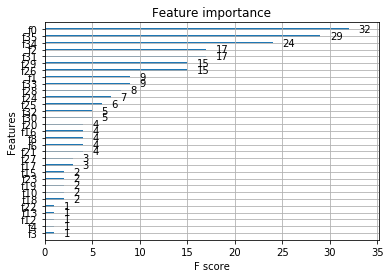

In [112]:
xgb.plot_importance(bst)

In [113]:
df_test = df_test_.copy()
df_test['shop_id']= df_test_.shop_id.astype('str')
df_test['item_id']= df_test_.item_id.astype('str')

df_test = df_test.merge(df_train_piv, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
df_test.head()

,ID,shop_id,item_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
d = dict(zip(df_test.columns[4:],list(np.array(list(df_test.columns[4:])) - 1)))
df_test  = df_test.rename(d, axis = 1)
df_test.head()

,ID,shop_id,item_id,bigcat,-1,0,1,2,3,4,...,23,24,25,26,27,28,29,30,31,32
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
preds = bst.predict(xgb.DMatrix(df_test.iloc[:, (df_test.columns != 'ID') & (df_test.columns != -1)].values))

# Normalize prediction to [0-20]
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
sub_df = pd.DataFrame({'ID':df_test.ID,'item_cnt_month': preds })
sub_df.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.237097
std,61834.358168,0.652846
min,0.000000,0.024921
25%,53549.750000,0.118123
50%,107099.500000,0.118123
75%,160649.250000,0.154479
max,214199.000000,20.000000


In [116]:
from datetime import datetime

sub_df.to_csv('submission/xgboost_{}.csv'.format(datetime.now().strftime('%Y-%m-%d %H-%M-%S')),index=False)

In [ ]:
kaggle competitions submit -c competitive-data-science-final-project -f submission.csv -m "Message"